In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict

import os

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [2]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [17]:
# ----- EXPERIMENT HPARAMS -----
META_FEATURES   = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

# ----- DATA HPARAMS -----
OUT_DIR       = '/mnt/swordfish-pool2/ndeas/prob_models/results2/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC      = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH   = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

BATCH_SIZE  = 128
NUM_WORKERS = 2

MAX_DF = 0.8
MIN_DF = 20

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

# ----- TRAINING HPARAMS -----

LR = 1e3
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

# ----- MODEL HPARAMS -----

NUM_TOPICS = 10
NUM_STYLES = 10
HIDDEN_DIM = 128
DROPOUT    = 0

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5.

STYLE_TOPIC_LINK = 'kappa_doc'

NUM_EPOCHS = 50

DEVICE = torch.device('cuda:0')

# ----- CONFIG/SAVING -----
date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,
}

PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

# Data Setup 

## Data Preprocessing/Loading

In [4]:
if not os.path.exists(DATA_DIR_PATH):
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = prepare_data(DATA_SRC,
                 SYNTHETIC_SRC,
                 SPLITS_PATH,
                 META_FEATURES,
                 DATA_DIR_PATH,
                 max_df = MAX_DF,
                 min_df = MIN_DF)
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR_PATH)   

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.8_mindf20_DATA


In [5]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [6]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [7]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [8]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [9]:
train_test_batch = next(iter(dl))
for k, v in train_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])


In [10]:
eval_test_batch = next(iter(eval_dl))
for k, v in eval_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])
bow_h1         
	               : torch.Size([128, 3098])
bow_h2         
	               : torch.Size([128, 3098])


# Training

## Setup

In [11]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[-0.0071,  0.0054, -0.1810,  ..., -0.2870,  0.0449, -0.0454],
        [-0.0067,  0.2180, -0.0308,  ...,  0.2856,  0.0195, -0.1911],
        [-0.2374,  0.2398, -0.2613,  ..., -0.0670, -0.1635,  0.0909],
        ...,
        [-0.1477,  0.2849, -0.2367,  ..., -0.1104, -0.1500,  0.1754],
        [-0.2630,  0.1940, -0.2316,  ..., -0.2347,  0.2915, -0.1126],
        [-0.2615, -0.1675, -0.0813,  ...,  0.1615, -0.2533,  0.2457]]), 'beta_style': tensor([[ 0.2321,  0.1739,  0.1539,  ...,  0.2026, -0.3143, -0.2198],
        [ 0.2959, -0.3009,  0.1217,  ...,  0.2117, -0.0306, -0.2556],
        [-0.1348, -0.2429,  0.1081,  ..., -0.0356, -0.0960, -0.0337],
        ...,
        [ 0.1134,  0.0755,  0.3084,  ..., -0.0497, -0.0513, -0.1269],
        [-0.1803,  0.1030,  0.0399,  ..., -0.0912,  0.2165,  0.1326],
        [ 0.0195,  0.0225,  0.1657,  ..., -0.0778,  0.2013, -0.2114]])}
{'casing': tensor([[ 0.2754,  0.1096, -0.0913],
        [ 0.0261,  0.2145,  0.3134],
        [-0.2768

## Training 

In [12]:
%%capture cap --no-stderr
pyro.clear_param_store()
prod_slda.train()

In [13]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [14]:
total_epochs = 0

In [15]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        batch = batch_to_device(batch, DEVICE)
        
        bow = batch['bow']
        meta = batch['meta']
        
        epoch_elbo += svi.step(bow, meta)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            
            batch = batch_to_device(batch, DEVICE)
            
            bow = batch['bow']
            meta = batch['meta']
    
            eval_elbo += svi.evaluate_loss(bow, meta)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

---TRAINING---


  0%|          | 0/521 [00:00<?, ?it/s]/home/ndeas/envs/test_env/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs_meta_emoji_task', 'obs_doc', 'obs_meta_sentiment_task', 'obs_meta_pos_bigrams', 'obs_meta_casing', 'obs_meta_formality', 'obs_meta_punc_tags'}
  warnings.warn(
100%|██████████| 179/179 [00:12<00:00, 14.10it/s]


Epoch 0: 17819.321
Epoch 0: Eval: 5961.097


100%|██████████| 179/179 [00:12<00:00, 14.58it/s]


Epoch 1: 17806.592
Epoch 1: Eval: 5944.042


  3%|▎         | 14/521 [00:01<00:47, 10.73it/s]


KeyboardInterrupt: 

In [18]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_10_20_44/model_epoch2_5944.042022705078.pt


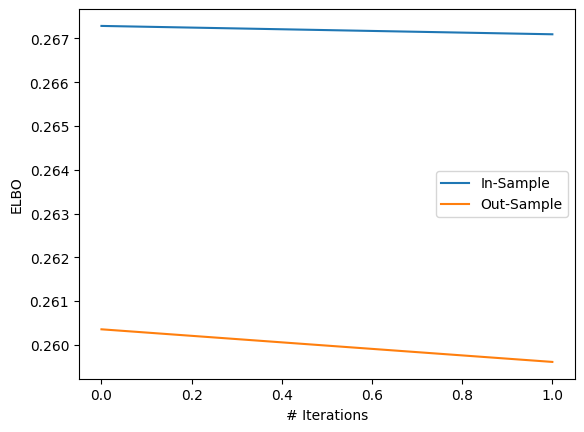

In [19]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig(os.path.join(PATH, 'loss_plot_indep.png'), dpi = 600, facecolor = None)


In [20]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_10_20_44/model_epoch2_5944.042022705078.pt


# Eval 

## Reconstruct Perplexity 

In [39]:
def calc_doc_perp(prod_slda, eval_dl, device, use_style = True):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.doc_reconstruct_ce(batch, use_style = use_style)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

def calc_style_perp(prod_slda, eval_dl, device):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.style_reconstruct_ce(batch)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

In [36]:
prod_slda = torch.load(path).to(DEVICE)

In [40]:
doc_perp      = calc_doc_perp(prod_slda, eval_dl)
doc_only_perp = calc_doc_perp(prod_slda, eval_dl, use_style = False)
style_perp    = calc_style_perp(prod_slda, eval_dl)

100%|██████████| 179/179 [00:12<00:00, 14.10it/s]


In [41]:
print(f'Perp           : {doc_perp:.4f}')
print(f'Perp (No Style): {doc_only_perp:.4f}')
print(f'Style Perp     : {style_perp:.4f}')

Perp           : 3199.2117
Perp (No Style): 3485.7412
Style Perp     : 56.1780


# Examine Topics 

In [52]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, min(top_k, logits.shape[1]), dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [53]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=10)
top_meta_per_latent = top_beta_meta(prod_slda, meta_features_to_names, top_k=10)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 10/10 [00:00<00:00, 118483.16it/s]

Document Term Info
	beta_topic (10):
		 beta_topic (0):
['wants', 'termination', 'general', 'caiso', 'q2', 'dial', 'ees', 'process', 'paso', 'results']

		 beta_topic (1):
['supervisor', 'contribute', 'thanx', 'addition', 'pulling', 'documents', 'years', 'brief', 'imbalance', 'gh']

		 beta_topic (2):
['mr', 'effective', 'yahoo', 'agreements', 'team', 'larry', '08', 'set', '20', 'pm']

		 beta_topic (3):
['mike', 'added', 'weekly', 'security', 'll', 'elizabeth', 'business', 'lets', 'kay', 'positions']

		 beta_topic (4):
['713', 'msn', 'delainey', 'look', 'fyi', 'robert', 'number', 'sure', 'think', 'letter']

		 beta_topic (5):
['reminder', 'jackie', 'soon', 'peak', 'theresa', 'cc', 'vacation', 'believe', 'est', 'language']

		 beta_topic (6):
['getting', 'christie', 'official', 'reports', 'pm', 'litigation', 'horton', 'unit', 'outlook', '646']

		 beta_topic (7):
['msn', '853', 'sara', 'analysis', 'fuel', 'car', 'assistance', 'latest', 'explorer', 'monday']

		 beta_topic (8):
['free'